In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ppo import PPO
from config_utils import get_config
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [3]:
# import gym
# env = gym.make("CartPole-v1")
# env = gym.make("CarRacing-v0")
"""
observation = env.reset()
for _ in range(100):
  env.render()
  action = env.action_space.sample() # your agent here (this takes random actions)
  observation, reward, done, info = env.step(action)

  if done:
        break
    #observation = env.reset()
env.close()
"""

'\nobservation = env.reset()\nfor _ in range(100):\n  env.render()\n  action = env.action_space.sample() # your agent here (this takes random actions)\n  observation, reward, done, info = env.step(action)\n\n  if done:\n        break\n    #observation = env.reset()\nenv.close()\n'

In [4]:
from envs import env_carracing_simple
env = env_carracing_simple.CarRacingSimple()

In [5]:
print(env.action_space)
print(env.action_space.shape)
print(env.observation_space)
print(env.observation_space.shape)
print(type(env.observation_space))

Box(3,)
(3,)
Box(96, 96, 3)
(96, 96, 3)
<class 'gym.spaces.box.Box'>


In [6]:
from actor_critics import ac_utils
print(ac_utils.get_generic_space_size(env.action_space))

3


In [7]:
config = get_config("configs/config-2020_06_02.json")
# config = get_config("configs/config-default_mujoco.json")

config.actor_critic["actor"]["learning_rate"] = 0.00005
config.actor_critic["critic"]["learning_rate"] = 0.00005
print(config)

# num_epochs = 1200
# num_epochs = 100
num_epochs = 2
minibatch_size = 1

if config.has_training:
    num_epochs = config.training.get("num_epochs", num_epochs)
    minibatch_size = config.training.get("minibatch_size", minibatch_size)

{'ppo_hyperparameters': {'epsilon': 0.2, 'discount_factor': 0.9, 'delta': 0.95, 'actor_critic': {'actor': {'learning_rate': 5e-05}, 'critic': {'learning_rate': 5e-05, 'alpha': 0.75}}}}


In [8]:
from actor_critics import carracing_fc_ac
actor = carracing_fc_ac.Actor(env)
critic = carracing_fc_ac.Critic(env)

ppo = PPO(
    env,
    config=config,
    actor=actor,
    critic=critic,
    no_cuda=True
)

In [9]:
loss_vals = []
pbar = tqdm(range(num_epochs))
for _ in pbar:
    #for _ in tqdm(range(minibatch_size), desc="minibatch"):
    step_loss_vals = ppo.step()
    loss_vals.append(sum(step_loss_vals) / len(step_loss_vals))
    tqdm.write(str(step_loss_vals))
    pbar.set_description("Loss = {:.6f}".format(loss_vals[-1]))

Track generation: 1094..1372 -> 278-tiles track
[0.5305849313735962, 0.6840220093727112, 0.6897242665290833, 0.6847507357597351, 0.6822046041488647, 0.6846773624420166, 0.6892306804656982, 0.693556547164917, 0.6975459456443787, 0.7001568078994751]
Track generation: 1128..1414 -> 286-tiles track
[1.1028485298156738, 1.1037713289260864, 1.1053913831710815, 1.1076838970184326, 1.1101365089416504, 1.1123754978179932, 1.1135727167129517, 1.1138534545898438, 1.114261269569397, 1.114793300628662]



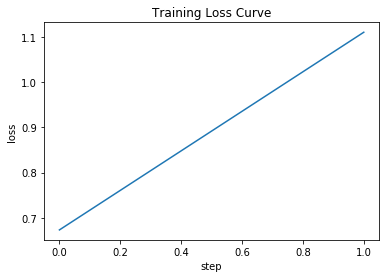

In [10]:
plt.plot(loss_vals)
plt.xlabel("step")
plt.ylabel("loss")
plt.title("Training Loss Curve")
plt.show()

In [11]:
import torch
from torch.autograd import Variable

In [17]:
#env_new = wrappers.Monitor(env, './video/', force = True)
times = 0
env_new = env
observation = env_new.reset()
# observation = Variable(torch.from_numpy(observation), requires_grad=False).to(ppo.torch_device)
observation = torch.unsqueeze(
    torch.from_numpy(observation.copy()),
    0
).to(ppo.torch_device)
for _ in range(100):
    env_new.render()
    action = torch.argmax(ppo.pi(observation.float())) 
    observation, reward, done, info = env_new.step(action.cpu().detach().numpy())
    # observation = Variable(torch.from_numpy(observation), requires_grad=False).to(ppo.torch_device)
    observation = torch.unsqueeze(
        torch.from_numpy(observation.copy()),
        0
    ).to(ppo.torch_device)
    if not done:
        times += 1
        
print(times)
env_new.close()

Track generation: 1171..1468 -> 297-tiles track
100
